In [1]:
import math
import random
import os

from app_settings import set_random_seed,set_global_settings
set_random_seed()
set_global_settings()



from pypinyin import pinyin, Style
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from IPython.display import display, Javascript
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from UCBCapstone_data_io import *
from UCBCapstone_data_prepare import *
from UCBCapstone_data_view import *
from UCBCapstone_models import *
from UCBCapstone_backtrader import *



%load_ext autoreload
%autoreload 2


2025-07-20 13:06:22.818510: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-20 13:06:22.832304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753041982.846700  209183 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753041982.850196  209183 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753041982.860390  209183 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Data loading and data preview

In [12]:
product='IC'
df_index_future, df_future_trading, df_index =read_all(product)



510500.SS already exists, skip downloading...


### Show the raw data for index future daily data which reflects the whole market for a particular index future product. 
    - Note, this is **different** from top dealer based index future trading data which offers a different view of future trading

In [13]:
df_index_future.head(1)

,Contract,Open,High,Low,Volume,Amount,OpenInterest,OpenInterestChange,Close,SettlementPrice,LastSettlementPrice,Change1,Change2,Delta
datetime,,,,,,,,,,,,,,
2020-01-02,IC2001,5300.0,5392.4,5281.0,68331,7312402.38,75083.0,2008.0,5361.8,5368.8,5266.8,95.0,102.0,--


In [14]:
df_index.head(1)

,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,4.914858,4.927542,4.83793,4.860752,269832060


In [15]:
df_future_trading.head()

,dealer,volume,volchange,buyvol,buyvolchange,sellvol,sellvolchange,net_vol_diff
datetime,,,,,,,,
2021-01-04,yideqihuo,2853.0,2664.0,0.0,0.0,0.0,0.0,0
2021-01-04,shanghaidongzheng,8644.0,65.0,9300.0,-166.0,8135.0,-558.0,392
2021-01-04,shanghaizhongqi,449.0,-14.0,0.0,0.0,0.0,0.0,0
2021-01-04,dongxingqihuo,5023.0,-52.0,3636.0,24.0,2284.0,292.0,-268
2021-01-04,dongwuqihuo,0.0,0.0,0.0,0.0,1574.0,35.0,-35


### Data understanding
- df_future_trading:
    - Contains trading information of top 20 traders in each category reported
    - The analysis below intends to find what might be useful for data modeling later
- 

### Data prepare
    - Add technical indicators

In [16]:
df_index= add_technical_indicators(df_index)
df_index= add_technical_return(df_index)

df_index.head(2)

,Close,High,Low,Open,Volume,SMA_20,SMA_50,RSI,MACD,Signal,Histogram,Bollinger_High,Bollinger_Low,Return
Date,,,,,,,,,,,,,,
2020-01-02,4.914858,4.927542,4.837930,4.860752,269832060,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
2020-01-03,4.923310,4.941910,4.903025,4.914015,176955991,NaN,NaN,99.999998,0.000674,0.000135,0.000539,NaN,NaN,0.00172


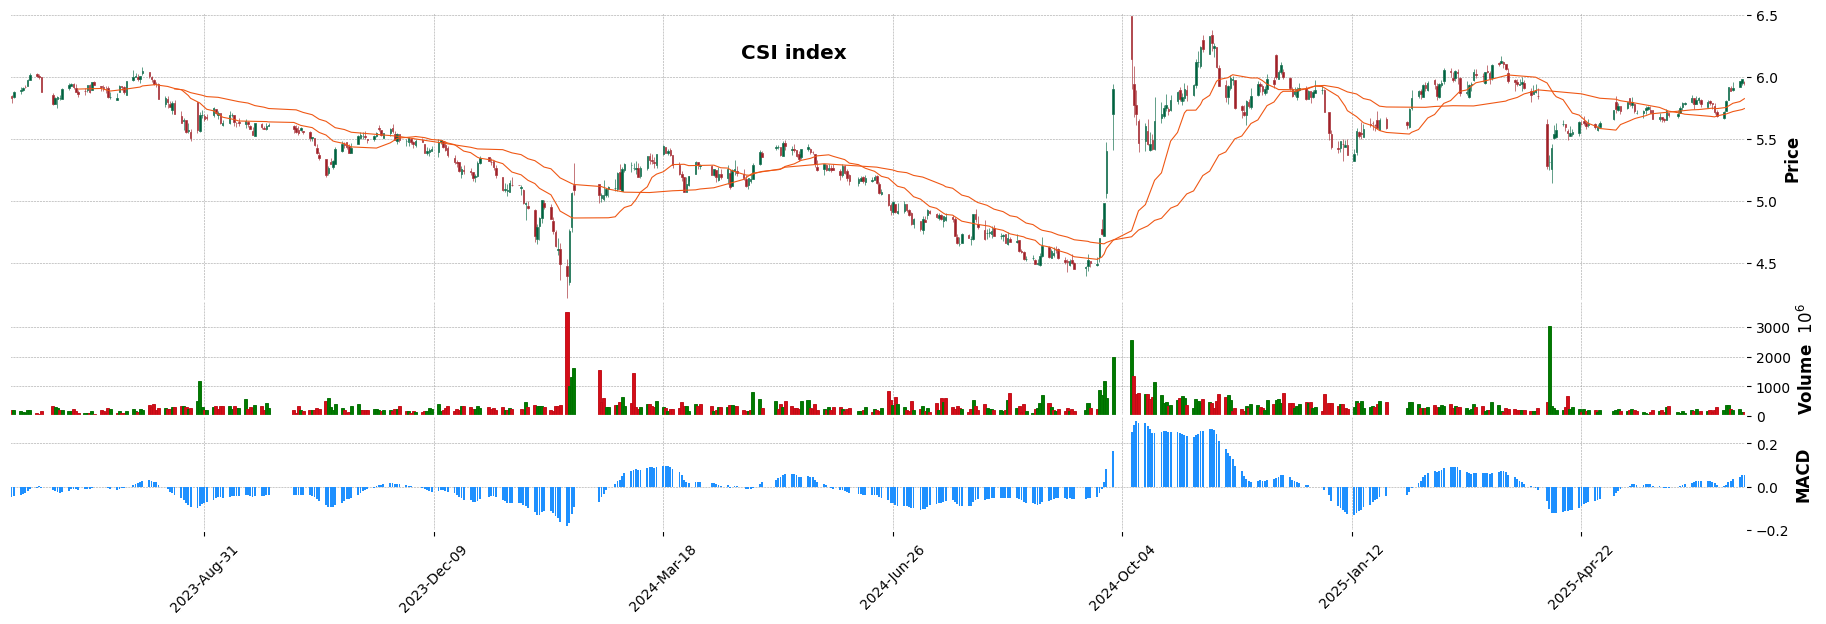

In [118]:
plot_csi_index(df_index)

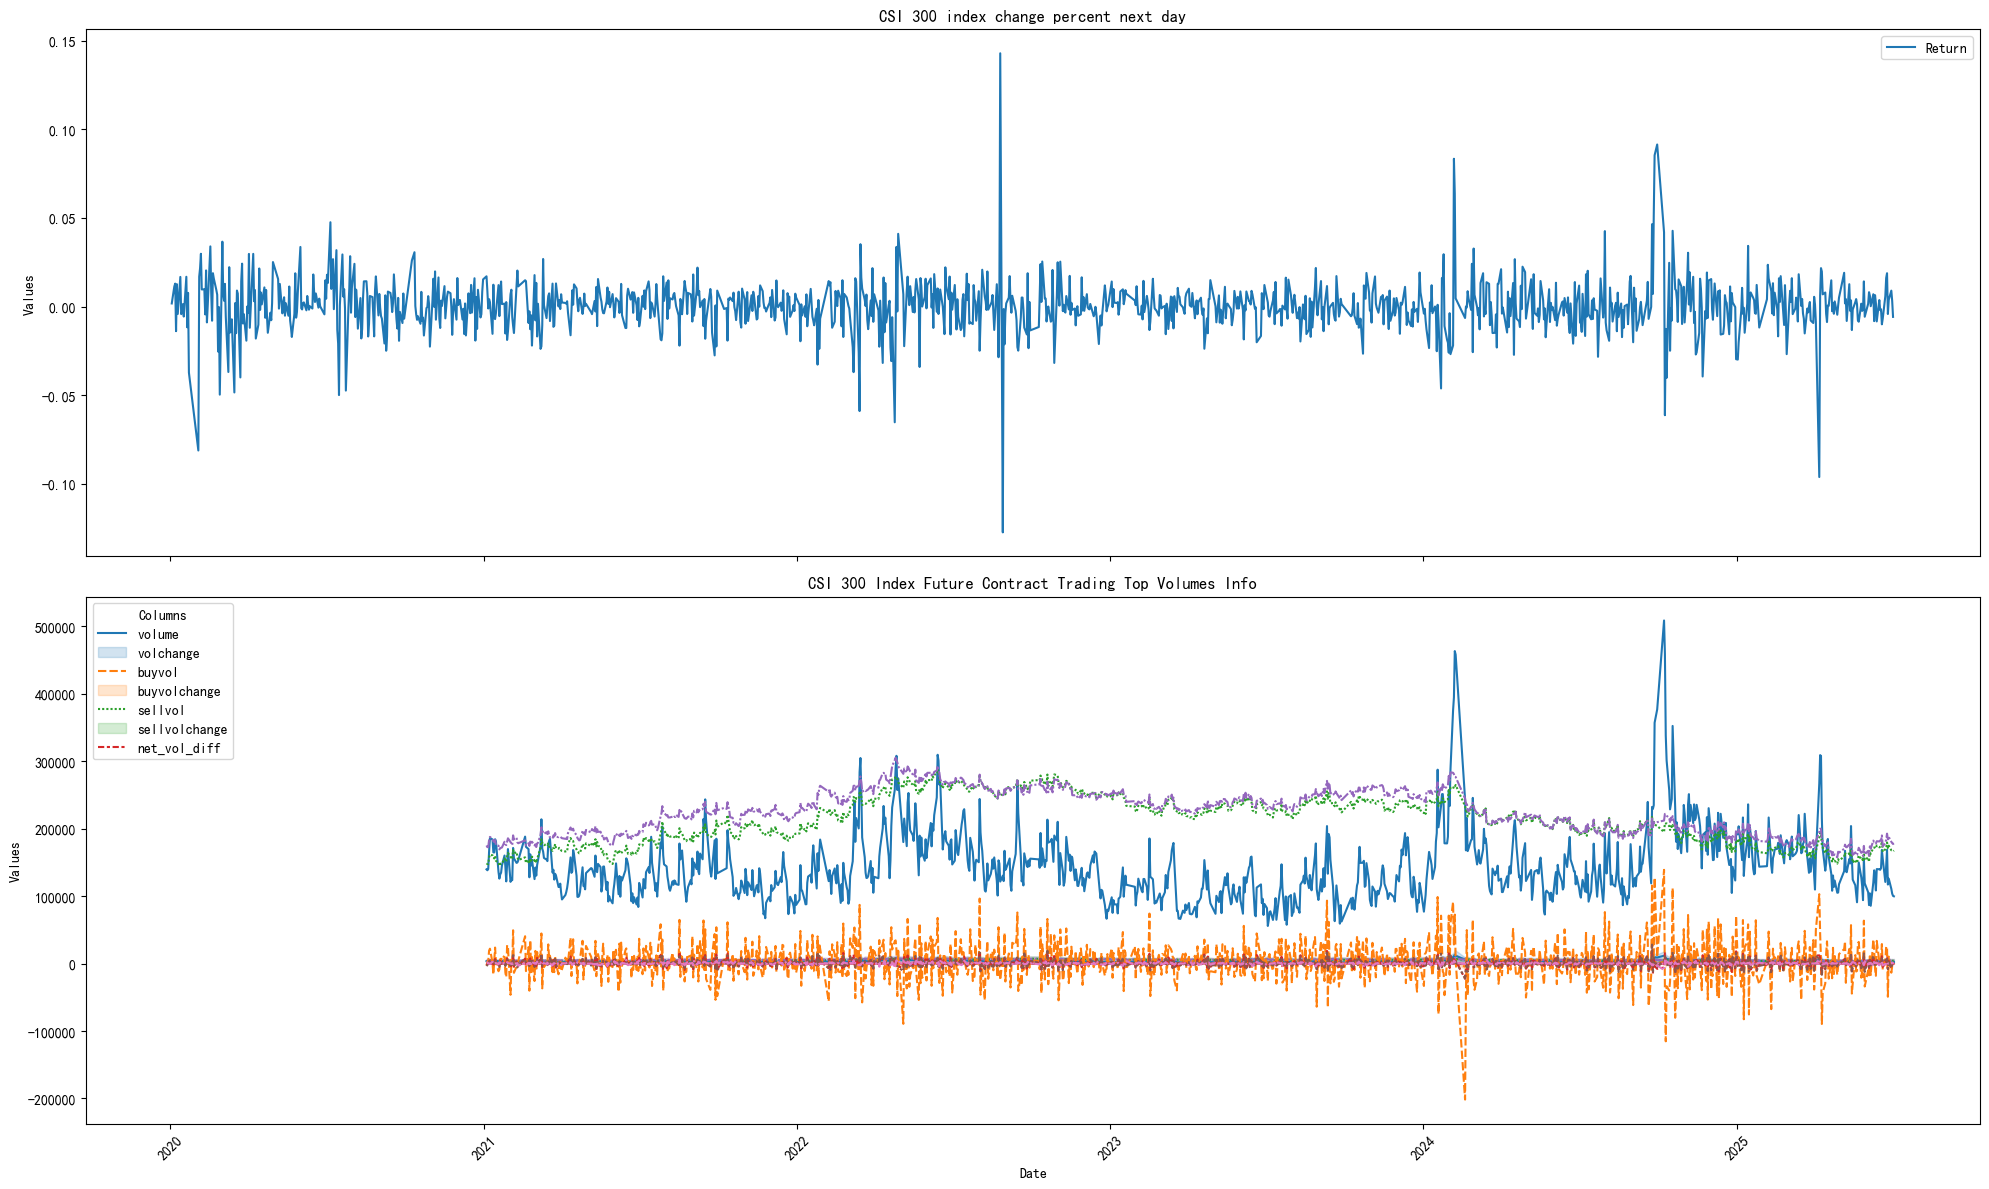

In [17]:
df_future_trading_by_date= group_future_trading_by_date(df_future_trading)
#print(df_future_trading_by_date.head(2))
plot_future_trading(df_index, df_future_trading,df_future_trading_by_date)

### Correlation and IC analysis between future contract trading data and CSI index change next day


#### The following analysis shows that
- Top 50 dealers contribute to 97.24% of total trading volume
- Top 100 dealers contribute to 99.73% of total trading volume

- Top 50 dealers will be more analysis in this notebook.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38692 entries, 2021-01-04 to 2025-07-03
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dealer         38692 non-null  object 
 1   volume         38692 non-null  float64
 2   volchange      38692 non-null  float64
 3   buyvol         38692 non-null  float64
 4   buyvolchange   38692 non-null  float64
 5   sellvol        38692 non-null  float64
 6   sellvolchange  38692 non-null  float64
 7   net_vol_diff   38692 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 2.7+ MB
None


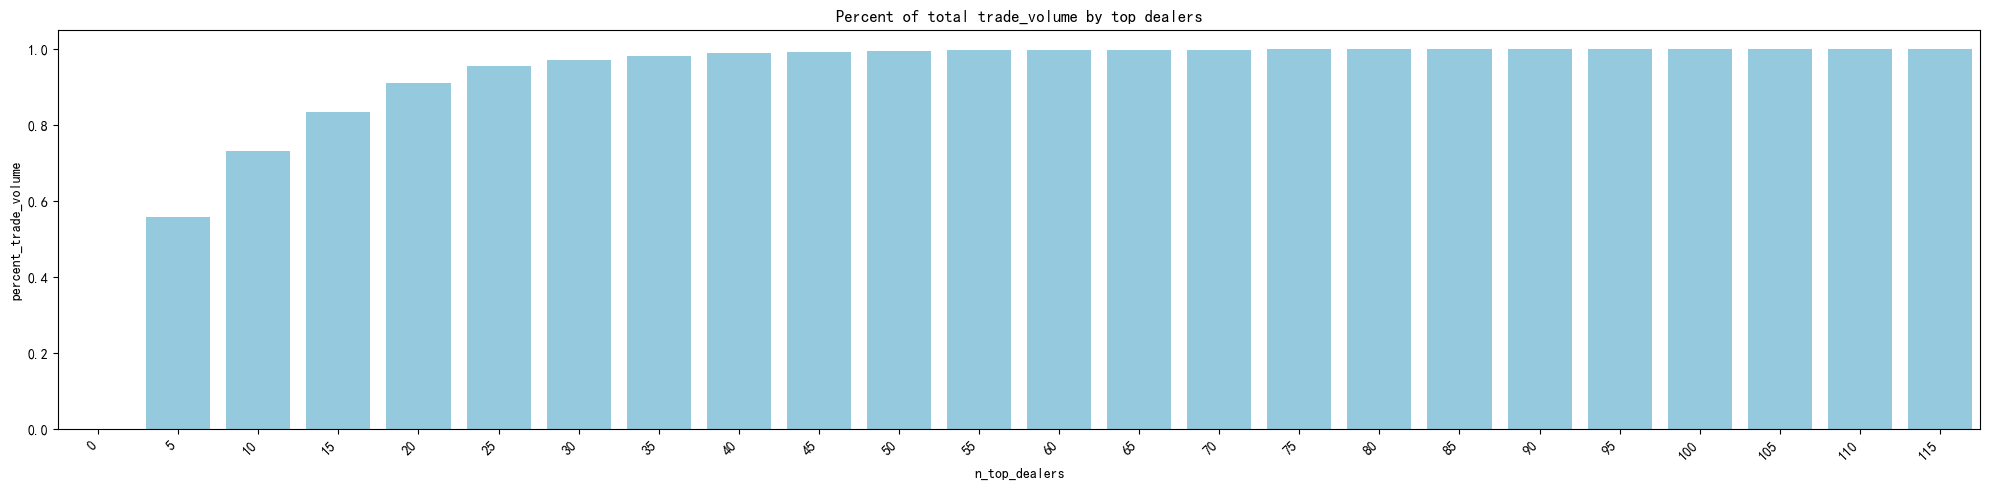

In [18]:
df_vol_percent=get_total_trade_vol_top_dealers(df_future_trading) 
plot_one(df_vol_percent,'barplot',x_col='n_top_dealers', y_col='percent_trade_volume', title='Percent of total trade_volume by top dealers', color='skyblue')
df_future_top=get_idx_future_top_traders(df_future_trading,50)
top_dealers=df_future_top['dealer'].unique()
print(df_future_top.info())


#### Find out the Information Coefficient (IC) between different future data columns of all dealers and CSI index change next data.
    - IF future contract volume seem to have highest IC with CSI index change next day
    - The future contract trading volume change has highest IC with CSI index change next day. Future contact buy volume and sell volume have high IC as well.
    - Surprisingly, the net trade volume has very small IC with the  CSI index change next day

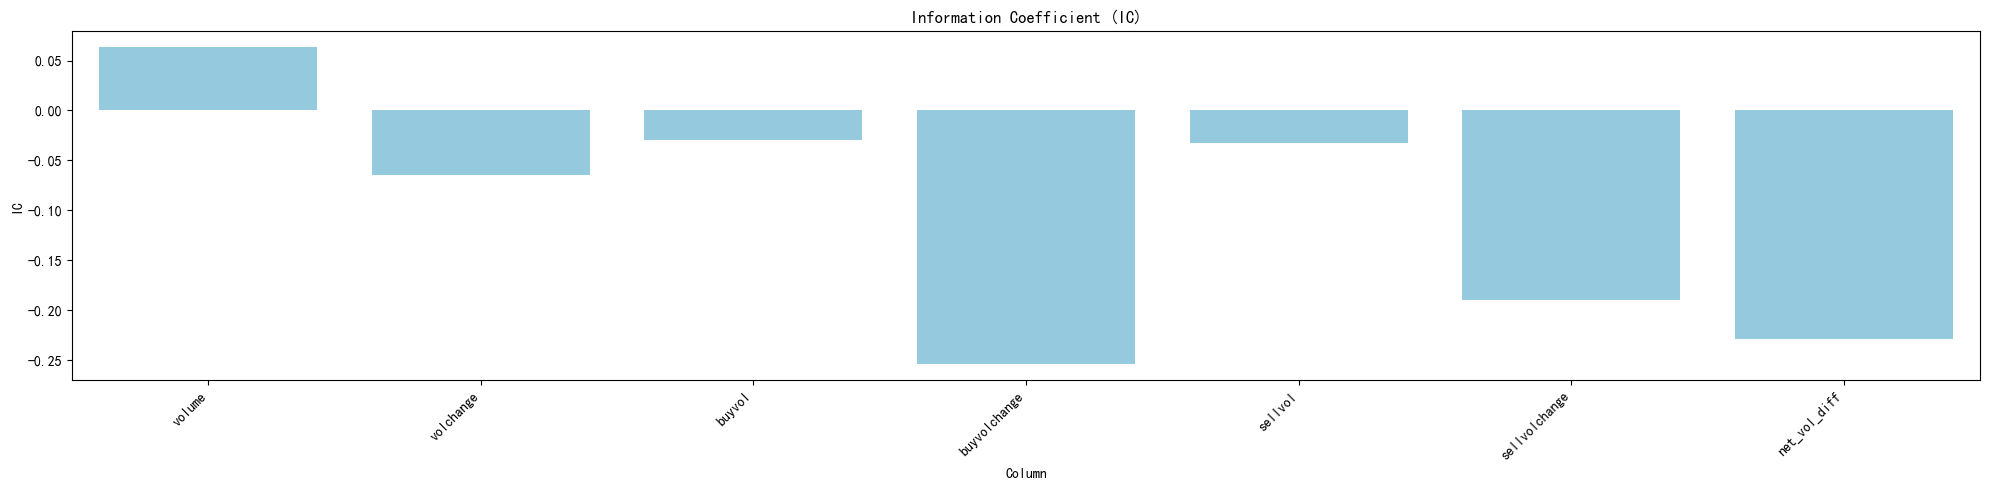

In [19]:
df_ic = cal_IC(df_index, df_future_top)
plot_one(df_ic,'barplot',x_col='Column', y_col='IC', title='Information Coefficient (IC)', color='skyblue')

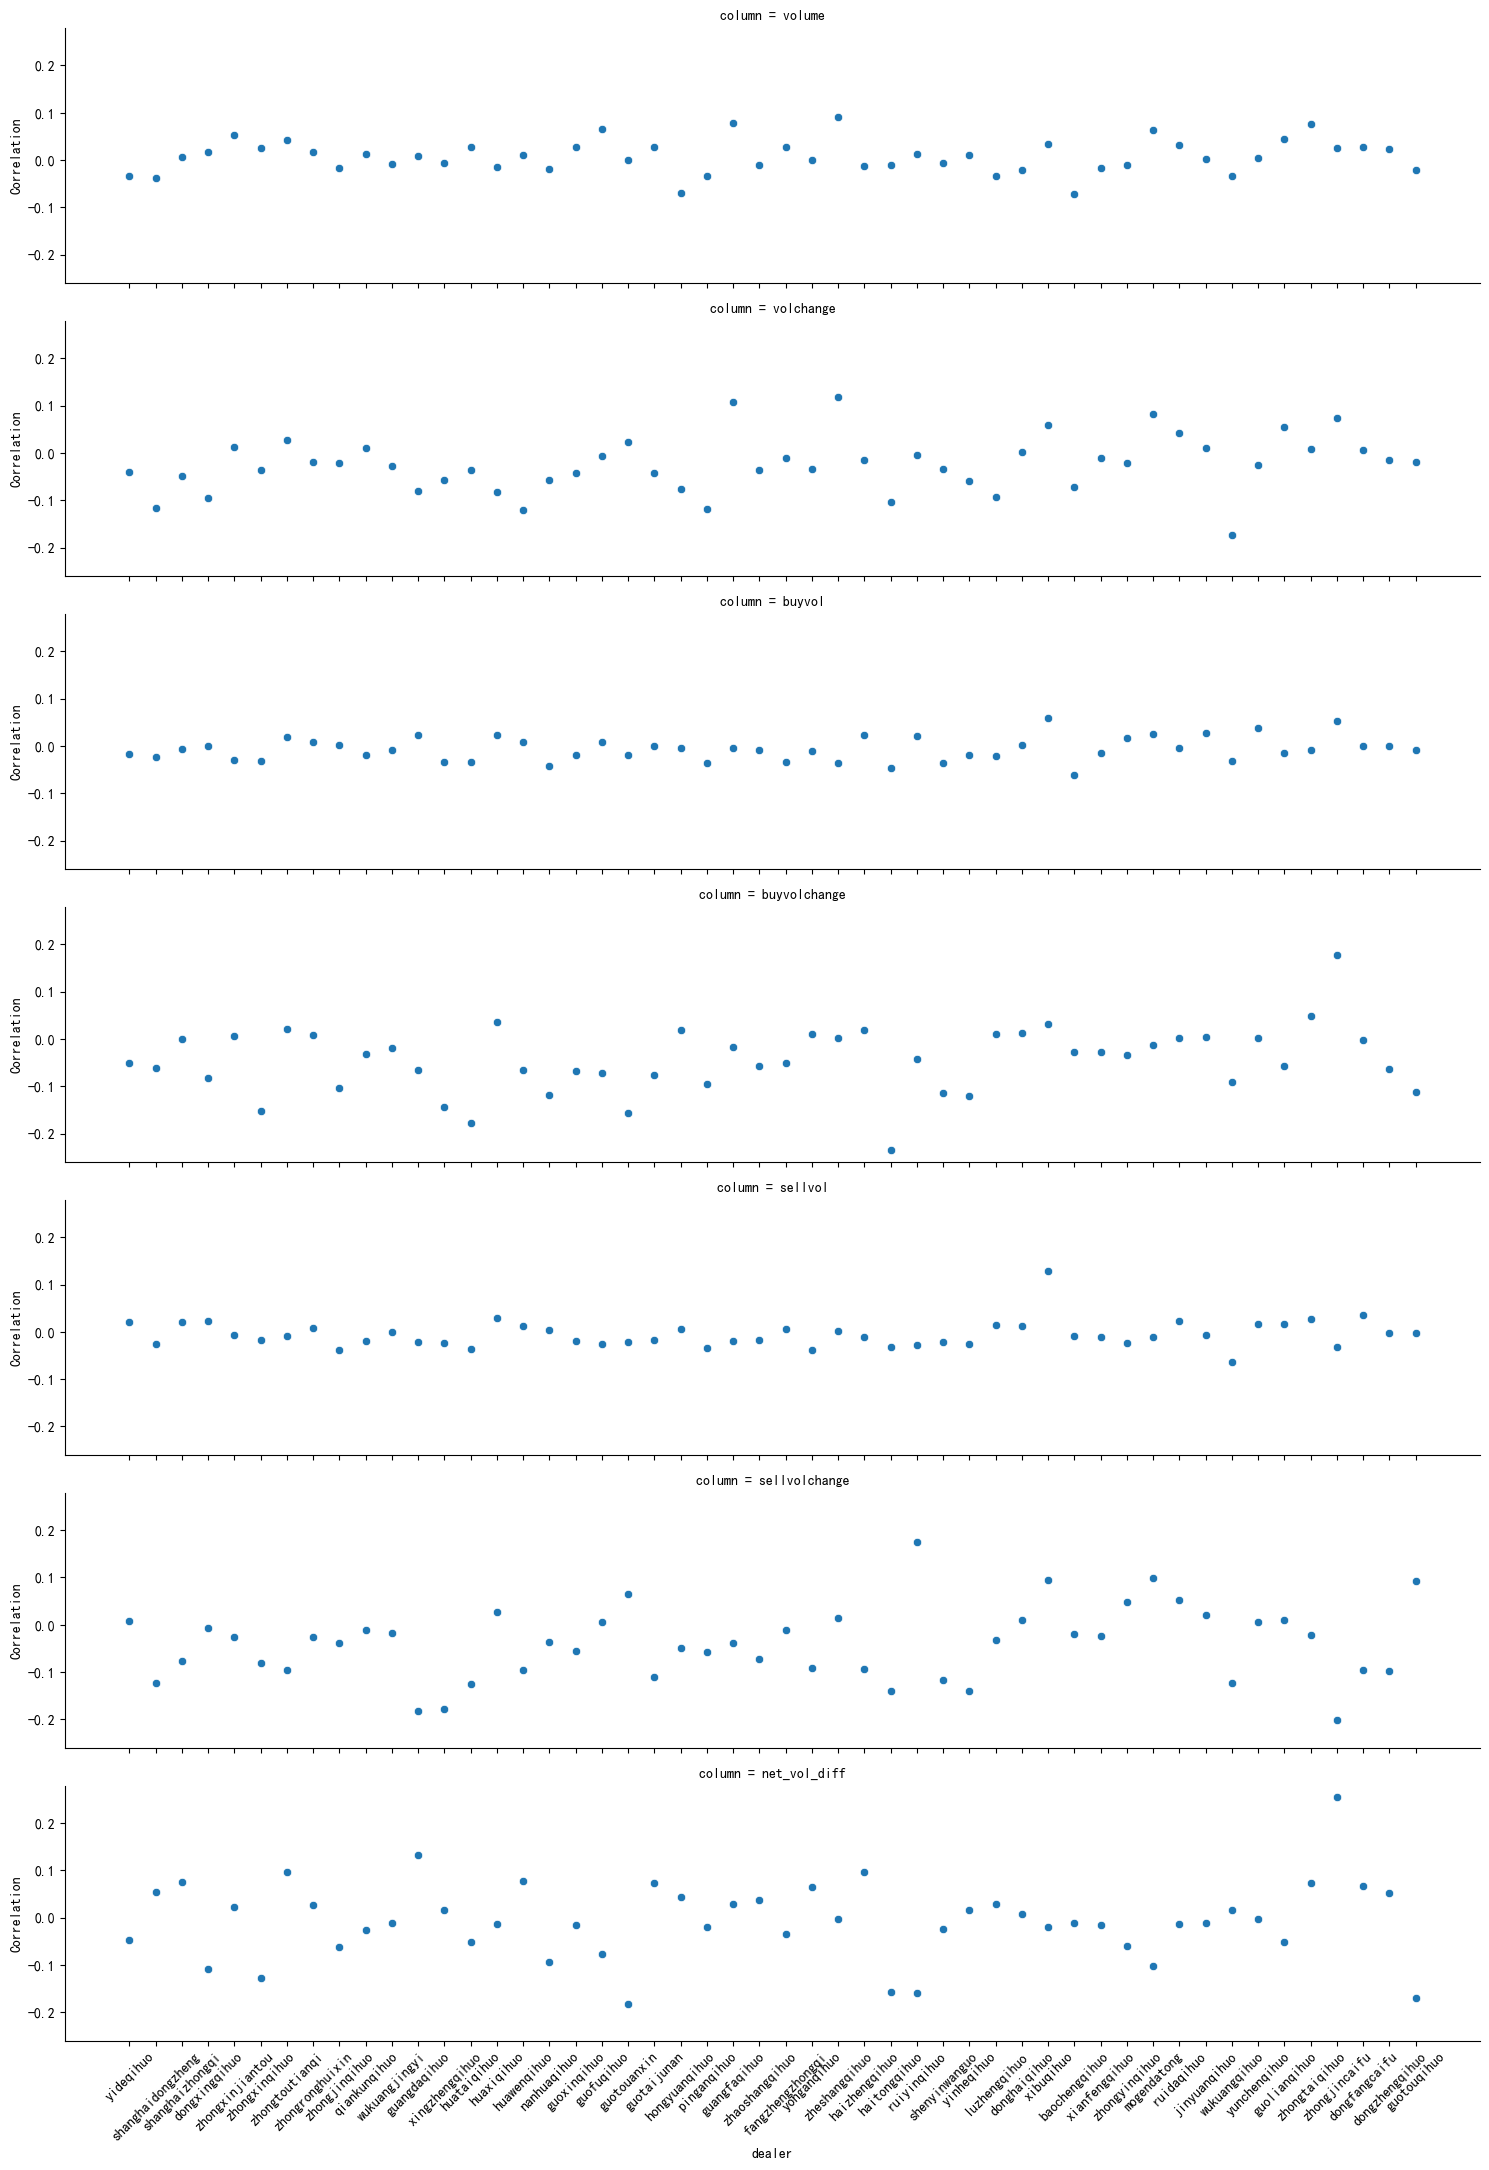

In [20]:
df_corr=cal_corr(df_index, df_future_top)

g=sns.relplot(
    data=df_corr, 
    x="dealer", y="Correlation", row='column', facet_kws={'sharex': True}, height=3,aspect=5,

)


for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45, labelright=True)

### Zoom in to see the correlation between future contract volume and CSI index change next day
    - those will highest future contract volume don't have the highest correlation 

/tmp/ipykernel_225599/4010687043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_by_vol['Abs_Correlation'] =abs(df_corr_by_vol['Correlation'])


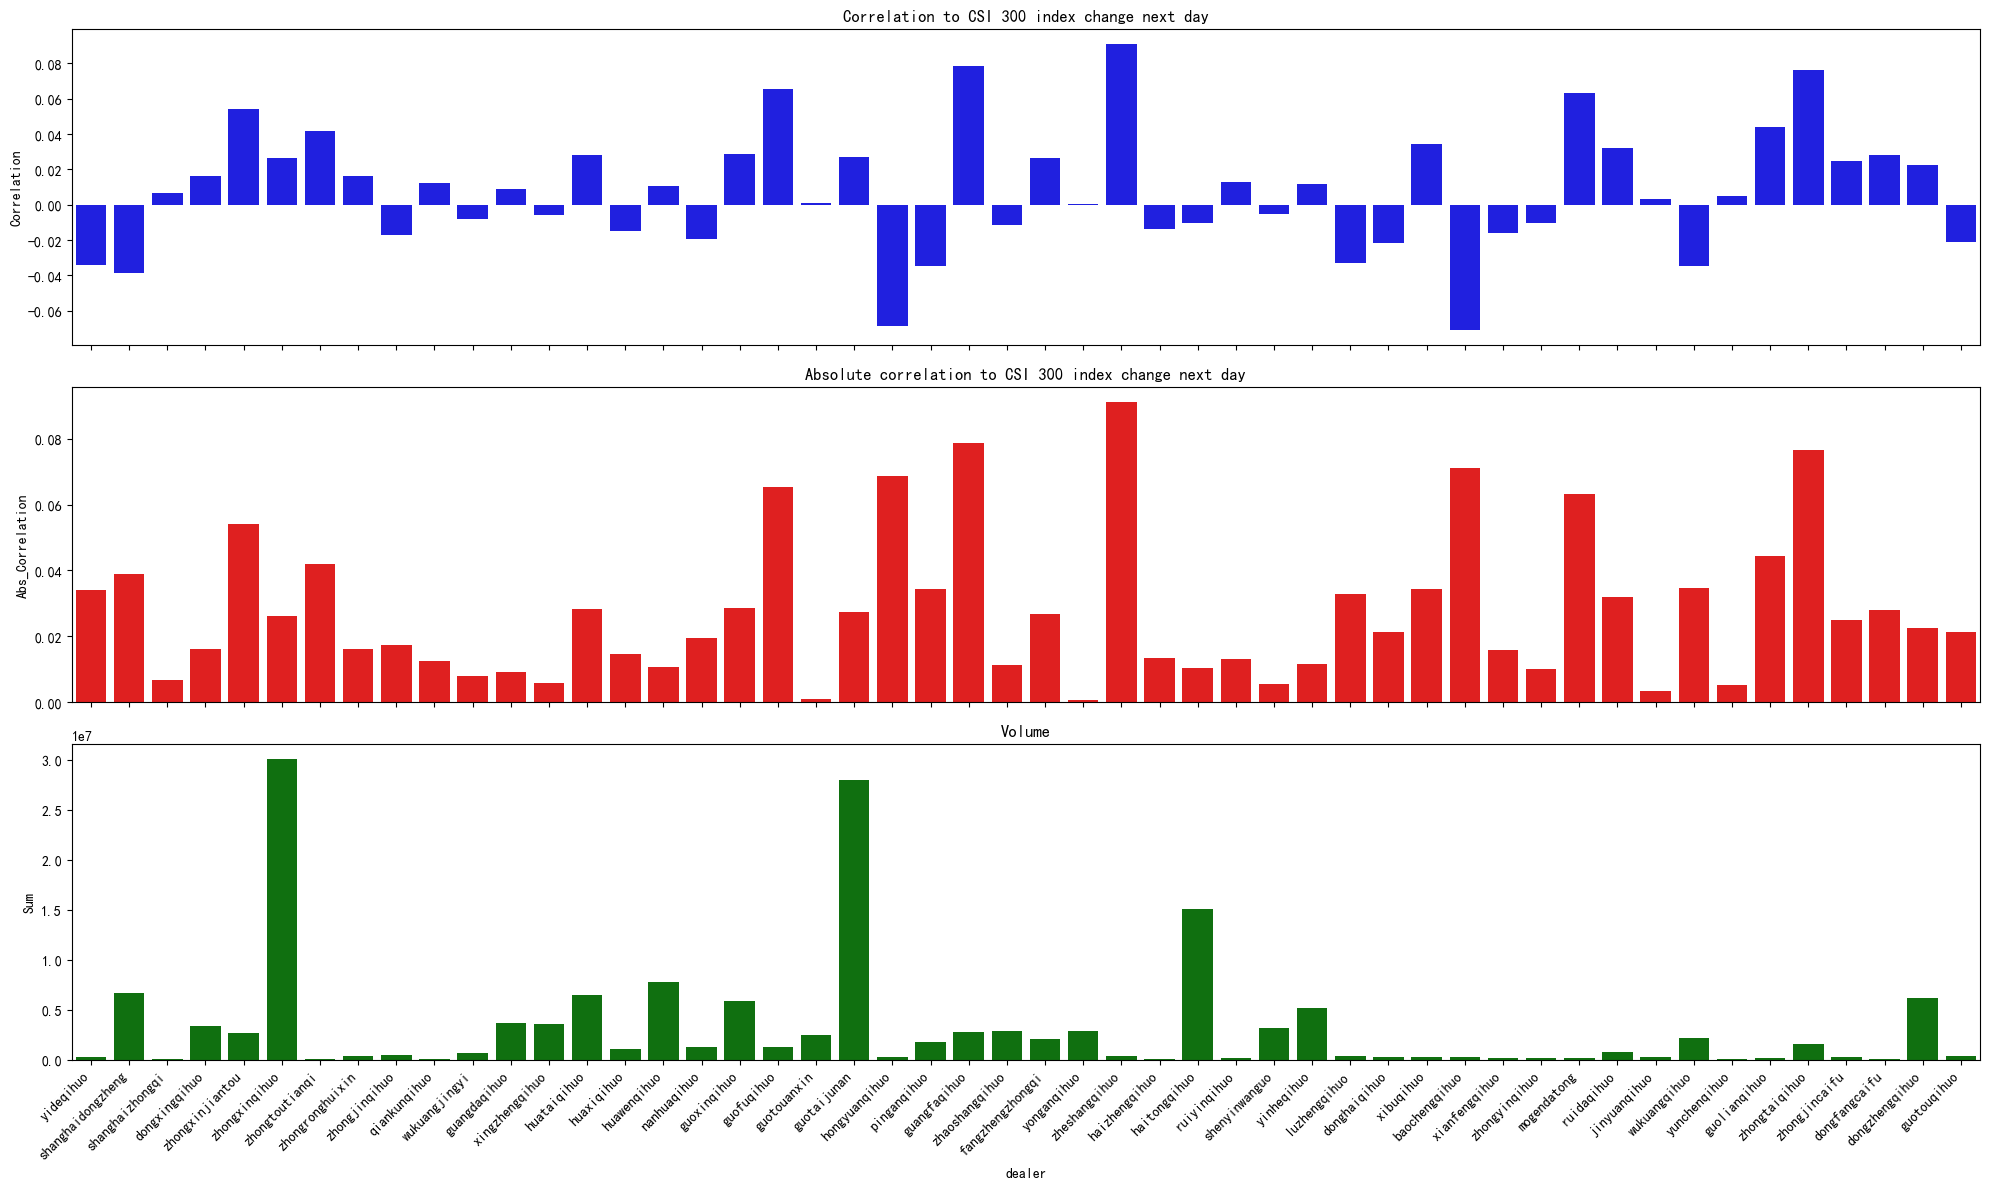

In [21]:
df_corr_by_vol= df_corr[df_corr['column']=='volume']
df_corr_by_vol['Abs_Correlation'] =abs(df_corr_by_vol['Correlation'])

plot_n(df_corr_by_vol,n=3, x_col='dealer', y_cols=['Correlation','Abs_Correlation','Sum'],titles=['Correlation to CSI 300 index change next day','Absolute correlation to CSI 300 index change next day','Volume'], colors=['blue','red','green'])


### Prepare data for model training
    - future contract trading data for all top 50 dealers will be pivoted into one row per trading day.
    - Only 20 out of 380+ columns are shown here 

In [ ]:
df_future_pivoted =pivote_df_future(df_future_top)
df_idx_with_future_trades =df_index.merge(df_future_pivoted, left_index=True, right_index=True, how='left').fillna(0)
df_idx_with_future_trades.dropna(inplace=True)
df_idx_with_future_trades[df_idx_with_future_trades.columns[:20]].tail(1)

,Close,High,Low,Open,Volume,SMA_20,SMA_50,RSI,MACD,Signal,Histogram,Bollinger_High,Bollinger_Low,Return,baochengqihuo_volume,dongfangcaifu_volume,donghaiqihuo_volume,dongxingqihuo_volume,dongzhengqihuo_volume,fangzhengzhongqi_volume
Date,,,,,,,,,,,,,,,,,,,,
2025-07-02,5.947,5.966,5.929,5.961,129745489,5.823,5.74292,60.590301,0.055469,0.035868,0.019601,5.992396,5.653603,-0.005851,0.0,0.0,539.0,0.0,7660.0,0.0


In [34]:
%load_ext autoreload
%autoreload 2
product = 'IF'

df_train_test_result= train_predict_all_models(product)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Train, test and predict on CSI future contract:"IF"...
000300.SS already exists, skip downloading...


2025-07-19 14:53:16.762710: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


2025-07-19 14:54:52.579466: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-19 14:56:45.574994: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


2025-07-19 14:59:39.946265: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step


In [35]:
df_train_test_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 0 to 10
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   product        11 non-null     object        
 1   model_name     11 non-null     object        
 2   IC%            11 non-null     float64       
 3   rmse           11 non-null     float64       
 4   prediction%    0 non-null      float64       
 5   start_date     11 non-null     datetime64[ns]
 6   last_date      11 non-null     datetime64[ns]
 7   model          11 non-null     object        
 8   history        3 non-null      object        
 9   feature_names  11 non-null     object        
dtypes: datetime64[ns](2), float64(3), object(5)
memory usage: 968.0+ bytes


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_34                │ (None, 363)            │           727 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1024)           │       372,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,930,908 (7.37 MB)

 Trainable params: 643,393 (2.45 MB)

 Non-trainable params: 727 (2.84 KB)

 Optimizer params: 1,286,788 (4.91 MB)

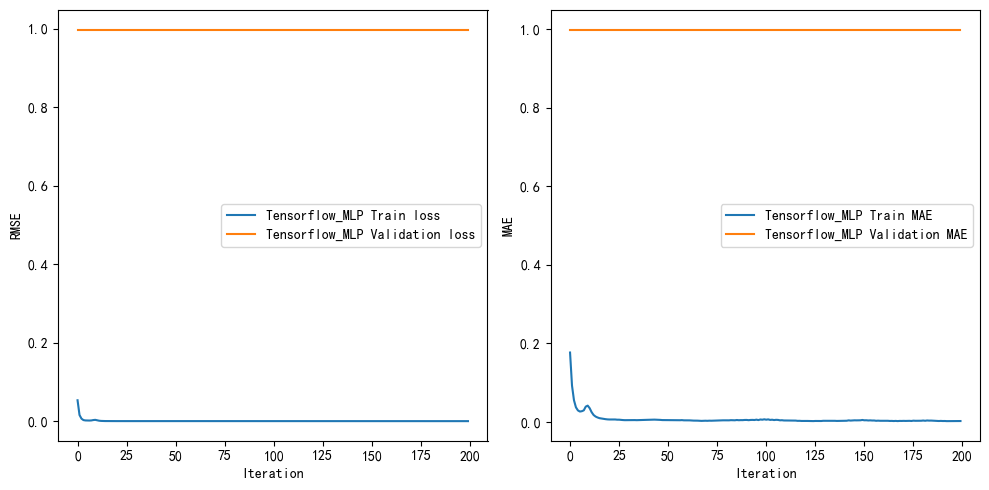

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_35                │ (None, None, 363)      │           727 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_33 (SimpleRNN)       │ (None, None, 1024)     │     1,421,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_34 (SimpleRNN)       │ (None, None, 256)      │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_35 (SimpleRNN)       │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,276,316 (20.13 MB)

 Trainable params: 1,758,529 (6.71 MB)

 Non-trainable params: 727 (2.84 KB)

 Optimizer params: 3,517,060 (13.42 MB)

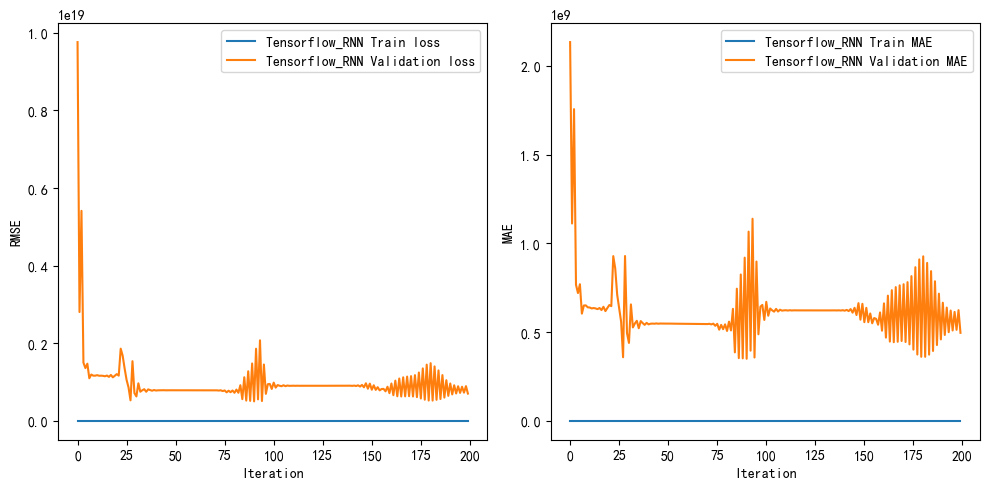

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_36                │ (None, None, 363)      │           727 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, None, 1024)     │     5,685,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, None, 256)      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 32)             │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,102,780 (80.50 MB)

 Trainable params: 7,034,017 (26.83 MB)

 Non-trainable params: 727 (2.84 KB)

 Optimizer params: 14,068,036 (53.67 MB)

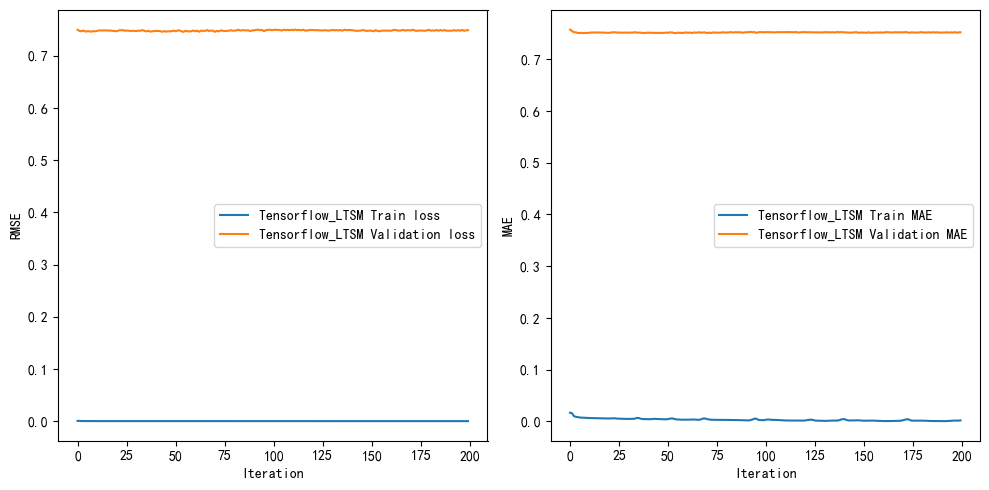

In [36]:
%load_ext autoreload
%autoreload 2
for model_name in ['Tensorflow_MLP', 'Tensorflow_RNN','Tensorflow_LTSM']:
    model=get_model(df_train_test_result, model_name)
    model.values[0].summary()
    plot_tensorflow_train_history(df_train_test_result, model_name)


In [37]:

voting_model=get_model(df_train_test_result, 'VotingRegressor').values[0]

In [129]:
voting_model

,estimators,"[('LinearRegression', ...), ('RidgeRegression', ...), ...]"
,weights,None
,n_jobs,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [38]:
df_train_test_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 0 to 10
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   product        11 non-null     object        
 1   model_name     11 non-null     object        
 2   IC%            11 non-null     float64       
 3   rmse           11 non-null     float64       
 4   prediction%    0 non-null      float64       
 5   start_date     11 non-null     datetime64[ns]
 6   last_date      11 non-null     datetime64[ns]
 7   model          11 non-null     object        
 8   history        3 non-null      object        
 9   feature_names  11 non-null     object        
dtypes: datetime64[ns](2), float64(3), object(5)
memory usage: 968.0+ bytes


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Feature Importance for LinearRegression:


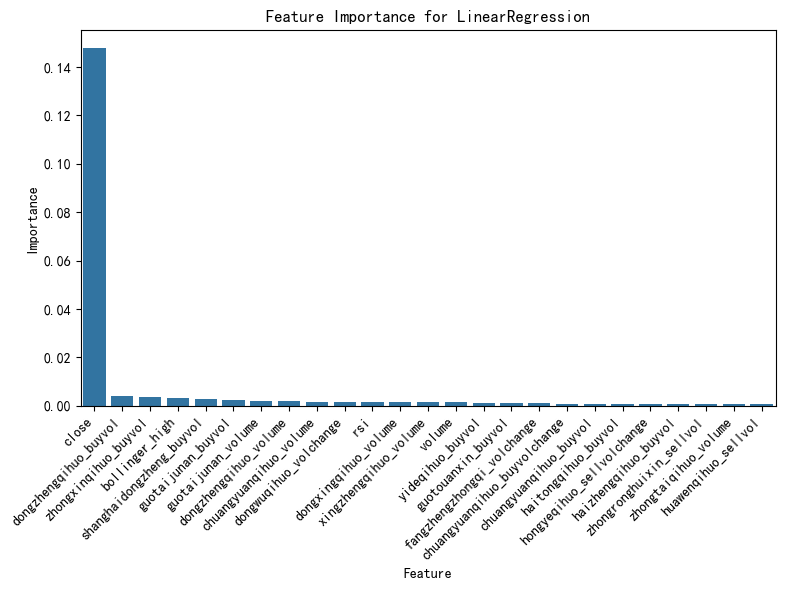


Feature Importance for RidgeRegression:


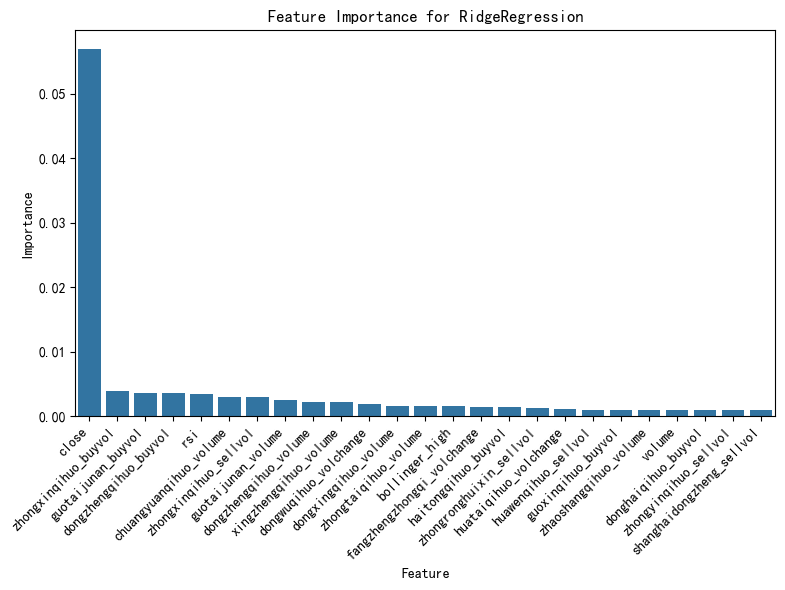


Feature Importance for KnnRegressor:

Feature Importance for DecisionTreeRegressor:


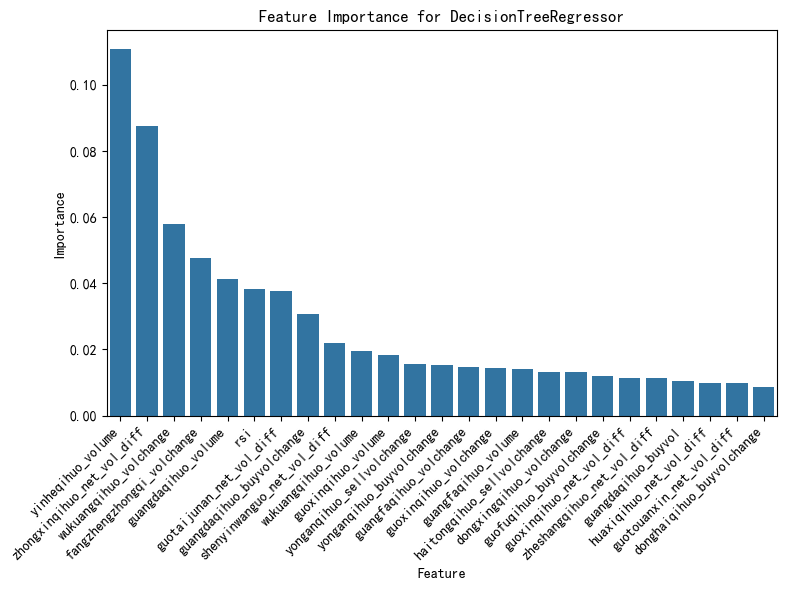


Feature Importance for TransformedTargetRegressor:


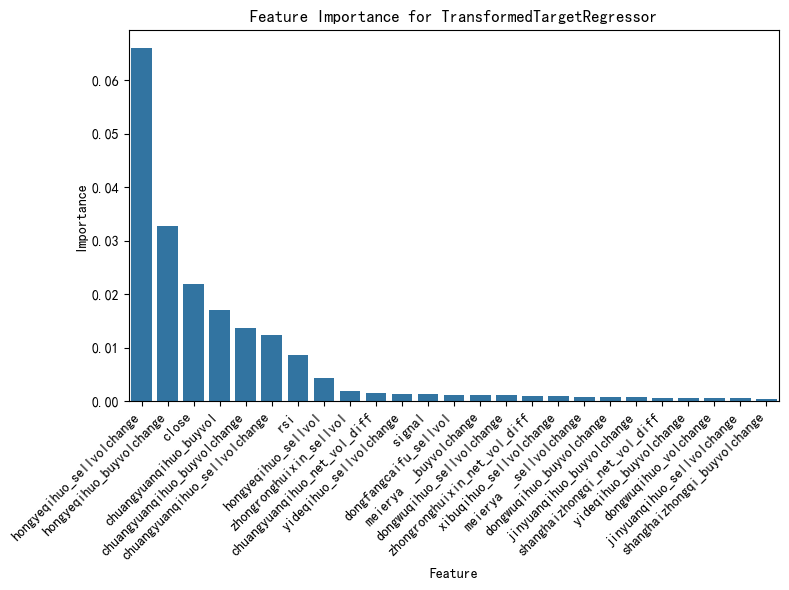


Feature Importance for AdaBoostRegressor:


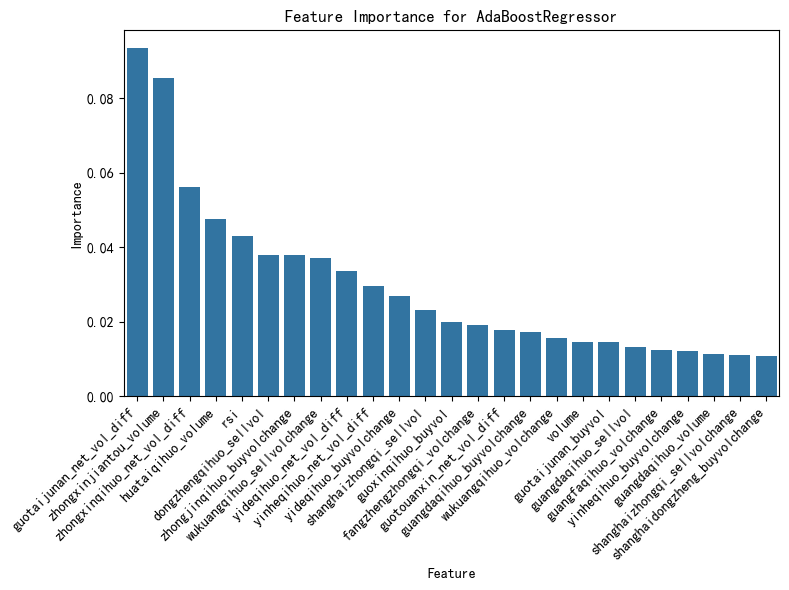


Feature Importance for XGBRegressor:


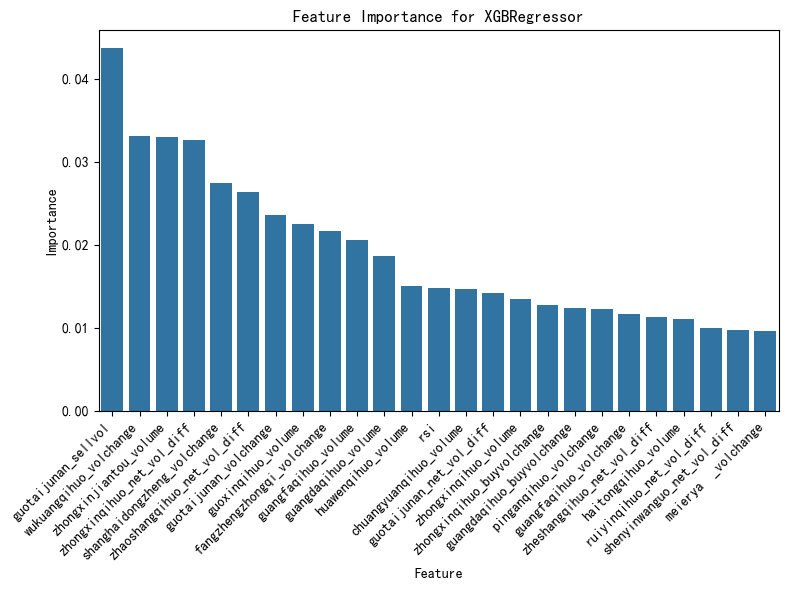

In [39]:
%load_ext autoreload
%autoreload 2
feature_names=get_deature_names(df_train_test_result)
#plot_feature_importance(voting_model,'RidgeRegression', feature_names)
#for model_name in ['LinearRegression','XGBRegressor']:
plot_feature_importance(voting_model, feature_names)


### add back tests

In [6]:
# load and split data into train set, validation set and test set. Test set does not overlap with other 2 sets at all.
product='IH'
X_train, y_train, X_val, y_val, X_test, y_test,df_close_test, start_date, end_date = load_and_preprocess_and_split_data(product)


510050.SS already exists, skip downloading...


#### back test for "VotingRegressor" model. This applies to all models with one row of data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Buy executed: Buy Price=2.610, Size=36100, Cash=5779.00
Trade closed: PnL (gross)=1841.10,  Cash=101841.104269 All traders pnl :1841.10
Buy executed: Buy Price=2.702, Size=35600, Cash=5649.91
Trade closed: PnL (gross)=462.80,  Cash=102303.904676 All traders pnl :2303.90
Buy executed: Buy Price=2.705, Size=35800, Cash=5464.91
Trade closed: PnL (gross)=143.21,  Cash=102447.111368 All traders pnl :2447.11
Buy executed: Buy Price=2.738, Size=35400, Cash=5521.91
Trade closed: PnL (gross)=424.80,  Cash=102871.914339 All traders pnl :2871.91
Buy executed: Buy Price=2.774, Size=35300, Cash=4949.72
Trade closed: PnL (gross)=-105.90,  Cash=102766.013598 All traders pnl :2766.01
Buy executed: Buy Price=2.813, Size=34600, Cash=5436.21
Trade closed: PnL (gross)=-519.00,  Cash=102247.018218 All traders pnl :2247.02
Buy executed: Buy Price=2.780, Size=34900, Cash=5225.02
Trade closed: PnL (gross)=-349.00,  Cash=10

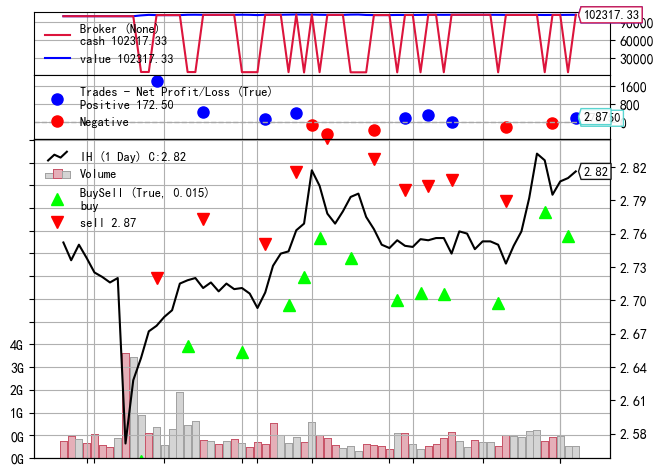

{'product': 'IH', 'model_name': 'VotingRegressor', 'IC%': 0.5708185341976454, 'MSE': 5.1265558365933864e-05, 'annual_return%': 0.4175759105569332, 'win_rate': 61.53846153846154, 'total_trades': 13, 'sharperatio': None, 'max_drawdown%': 0.9467071692500941}


In [19]:
%load_ext autoreload
%autoreload 2


%matplotlib inline

model_name= "VotingRegressor"
model = models[model_name]
#backtest(product, model_name, model,X_train, y_train, X_val, y_val, X_test, y_test,df_close_test,verbose=1)
model_name, ic,mse,annual_return, sharperatio, max_drawdown,win_rate, total_trades =backtest(product, model_name, model,X_train, y_train, X_val, y_val, X_test, y_test, df_close_test, start_date, end_date, verbose=1)
back_test_result={"product": product,"model_name":model_name, 'IC%':ic,'MSE':mse, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown}
print(back_test_result)

#### back test for Tensorflow LTSM model. This applies to Tensorflow RNN model as well. Both of this need to look back periods of data

In [24]:
model_name='Tensorflow_LTSM'
model_name, ic_from_model,mse,annual_return, sharperatio, max_drawdown,win_rate, total_trades =backtest(product, model_name, None, X_train, y_train, X_val, y_val, X_test, y_test, df_close_test, start_date, end_date, verbose=0,epochs=20)
back_test_result={"product": product,"model_name":model_name, 'IC%':ic,'MSE':mse, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown}
print(back_test_result)


2025-07-19 10:45:09.887982: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
               Tensorflow_LTSM: Final Portfolio Value:101288.58 annual_return: 0.23%     win_rate: 50.00%   total_trades: 12    Sharpe Ratio: None max drawdown: 3.69
{'product': 'IH', 'model_name': 'Tensorflow_LTSM', 'IC%': 0.5708185341976454, 'MSE': 0.9816999779327004, 'annual_return%': 0.2331635417823108, 'win_rate': 50.0, 'total_trades': 12, 'sharperatio': None, 'max_drawdown%': 3.688806438446045}


#### test all models

In [10]:
%load_ext autoreload
%autoreload 2
df_backtest_result= backtest_all_products('IH,IF,IC,IM',verbose=0, epochs=200)
df_backtest_result


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
510050.SS already exists, skip downloading...
              LinearRegression: product:   IH   Final Portfolio Value:    101088.64     annual_return: 0.20%     win_rate: 36.36%   total_trades:  11  Sharpe Ratio: 0.03      max drawdown: 1.23
               RidgeRegression: product:   IH   Final Portfolio Value:    101999.94     annual_return: 0.36%     win_rate: 50.00%   total_trades:   2  Sharpe Ratio: 0.10      max drawdown: 0.88
                  KnnRegressor: product:   IH   Final Portfolio Value:    104185.12     annual_return: 0.75%     win_rate: 62.50%   total_trades:  16  Sharpe Ratio: 0.10      max drawdown: 3.47
         DecisionTreeRegressor: product:   IH   Final Portfolio Value:    102579.30     annual_return: 0.46%     win_rate: 68.75%   total_trades:  16  Sharpe Ratio: 0.04      max drawdown: 5.17
    TransformedTargetRegressor: product:   IH   Final Portfolio Value:    101088.64     an

2025-07-19 13:57:26.743595: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
               Tensorflow_LTSM: product:   IH   Final Portfolio Value:    102187.82     annual_return: 0.39%     win_rate: 45.45%   total_trades:  11  Sharpe Ratio: 0.08      max drawdown: 1.23


2025-07-19 14:00:27.411071: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
                Tensorflow_RNN: product:   IH   Final Portfolio Value:    101387.79     annual_return: 0.25%     win_rate: 53.33%   total_trades:  15  Sharpe Ratio: 0.03      max drawdown: 2.47


2025-07-19 14:00:42.591909: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step

2025-07-19 14:03:07.382459: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


2025-07-19 14:03:12.397732: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


                Tensorflow_MLP: product:   IH   Final Portfolio Value:    101238.41     annual_return: 0.22%     win_rate: 66.67%   total_trades:  15  Sharpe Ratio: 0.03      max drawdown: 2.94
000300.SS already exists, skip downloading...
              LinearRegression: product:   IF   Final Portfolio Value:    104211.25     annual_return: 0.75%     win_rate: 75.00%   total_trades:   4  Sharpe Ratio: 0.15      max drawdown: 2.38
               RidgeRegression: product:   IF   Final Portfolio Value:    104791.75     annual_return: 0.86%     win_rate: 50.00%   total_trades:   2  Sharpe Ratio: 0.16      max drawdown: 2.55
                  KnnRegressor: product:   IF   Final Portfolio Value:    101722.18     annual_return: 0.31%     win_rate: 50.00%   total_trades:  10  Sharpe Ratio: 0.06      max drawdown: 2.32
         DecisionTreeRegressor: product:   IF   Final Portfolio Value:    104865.50     annual_return: 0.87%     win_rate: 70.00%   total_trades:  10  Sharpe Ratio: 0.21      max

2025-07-19 14:06:53.320969: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
               Tensorflow_LTSM: product:   IF   Final Portfolio Value:    99128.49     annual_return: -0.16%     win_rate: 0.00%   total_trades:   3  Sharpe Ratio: -0.25      max drawdown: 0.87


2025-07-19 14:08:52.773754: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-19 14:08:52.819450: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
                Tensorflow_RNN: product:   IF   Final Portfolio Value:    100000.00     annual_return: 0.00%     win_rate: 0.00%   total_trades:   0  Sharpe Ratio: 0.00      max drawdown: 0.00


2025-07-19 14:09:01.400355: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


2025-07-19 14:10:35.082230: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


                Tensorflow_MLP: product:   IF   Final Portfolio Value:    104645.25     annual_return: 0.83%     win_rate: 0.00%   total_trades:   0  Sharpe Ratio: 0.16      max drawdown: 2.56
510500.SS already exists, skip downloading...
              LinearRegression: product:   IC   Final Portfolio Value:    108808.31     annual_return: 1.55%     win_rate: 50.00%   total_trades:   4  Sharpe Ratio: 0.19      max drawdown: 2.38
               RidgeRegression: product:   IC   Final Portfolio Value:    107558.41     annual_return: 1.33%     win_rate: 25.00%   total_trades:   4  Sharpe Ratio: 0.16      max drawdown: 2.38
                  KnnRegressor: product:   IC   Final Portfolio Value:    101442.06     annual_return: 0.26%     win_rate: 40.00%   total_trades:   5  Sharpe Ratio: 0.02      max drawdown: 6.66
         DecisionTreeRegressor: product:   IC   Final Portfolio Value:    103723.43     annual_return: 0.67%     win_rate: 53.33%   total_trades:  15  Sharpe Ratio: 0.11      max 

2025-07-19 14:14:32.978936: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
               Tensorflow_LTSM: product:   IC   Final Portfolio Value:    99696.18     annual_return: -0.06%     win_rate: 0.00%   total_trades:   1  Sharpe Ratio: -0.26      max drawdown: 0.39


2025-07-19 14:17:06.227570: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
                Tensorflow_RNN: product:   IC   Final Portfolio Value:    91349.70     annual_return: -1.63%     win_rate: 52.94%   total_trades:  17  Sharpe Ratio: -0.12      max drawdown: 10.68


2025-07-19 14:17:17.103957: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2025-07-19 14:19:12.207951: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-19 14:19:18.226635: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

                Tensorflow_MLP: product:   IC   Final Portfolio Value:    99508.88     annual_return: -0.09%     win_rate: 58.33%   total_trades:  12  Sharpe Ratio: -0.03      max drawdown: 3.89
512100.SS already exists, skip downloading...
              LinearRegression: product:   IM   Final Portfolio Value:    103233.33     annual_return: 1.09%     win_rate: 0.00%   total_trades:   0  Sharpe Ratio: 0.10      max drawdown: 3.08
               RidgeRegression: product:   IM   Final Portfolio Value:    103233.33     annual_return: 1.09%     win_rate: 0.00%   total_trades:   0  Sharpe Ratio: 0.10      max drawdown: 3.08
                  KnnRegressor: product:   IM   Final Portfolio Value:    99824.57     annual_return: -0.06%     win_rate: 60.00%   total_trades:   5  Sharpe Ratio: -0.06      max drawdown: 0.89
         DecisionTreeRegressor: product:   IM   Final Portfolio Value:    102080.39     annual_return: 0.70%     win_rate: 55.56%   total_trades:   9  Sharpe Ratio: 0.09      max

2025-07-19 14:21:50.372495: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
               Tensorflow_LTSM: product:   IM   Final Portfolio Value:    101831.04     annual_return: 0.62%     win_rate: 66.67%   total_trades:   3  Sharpe Ratio: 0.08      max drawdown: 2.82


2025-07-19 14:23:29.783440: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
                Tensorflow_RNN: product:   IM   Final Portfolio Value:    103134.59     annual_return: 1.05%     win_rate: 14.29%   total_trades:   7  Sharpe Ratio: 0.14      max drawdown: 2.90


2025-07-19 14:23:35.126736: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


2025-07-19 14:24:44.553157: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


                Tensorflow_MLP: product:   IM   Final Portfolio Value:    103271.87     annual_return: 1.10%     win_rate: 71.43%   total_trades:   7  Sharpe Ratio: 0.21      max drawdown: 1.54


,product,model_name,IC%,MSE,annual_return%,win_rate,total_trades,sharperatio,max_drawdown%
0,IH,LinearRegression,59.137167,4.425738e-05,0.197144,36.363636,11,0.033510,1.226869
1,IH,RidgeRegression,33.335994,1.405721e-04,0.360843,50.000000,2,0.096074,0.883643
2,IH,KnnRegressor,-1.963562,9.371028e-05,0.748552,62.500000,16,0.095910,3.468588
3,IH,DecisionTreeRegressor,32.675226,8.701422e-05,0.464293,68.750000,16,0.044037,5.168186
4,IH,TransformedTargetRegressor,59.137167,4.425715e-05,0.197144,36.363636,11,0.033510,1.226869
5,IH,AdaBoostRegressor,17.694659,6.535469e-05,0.226666,57.142857,7,0.026012,2.731649
6,IH,XGBRegressor,24.121004,6.213977e-05,0.589273,66.666667,9,0.093805,2.313842
7,IH,VotingRegressor,57.081853,5.310142e-05,0.273751,44.444444,9,0.059235,1.285824
8,IH,Tensorflow_LTSM,15.495255,9.825646e-01,0.394444,45.454545,11,0.078956,1.227821
9,IH,Tensorflow_RNN,-20.479094,1.305353e+17,0.251014,53.333333,15,0.029246,2.466315


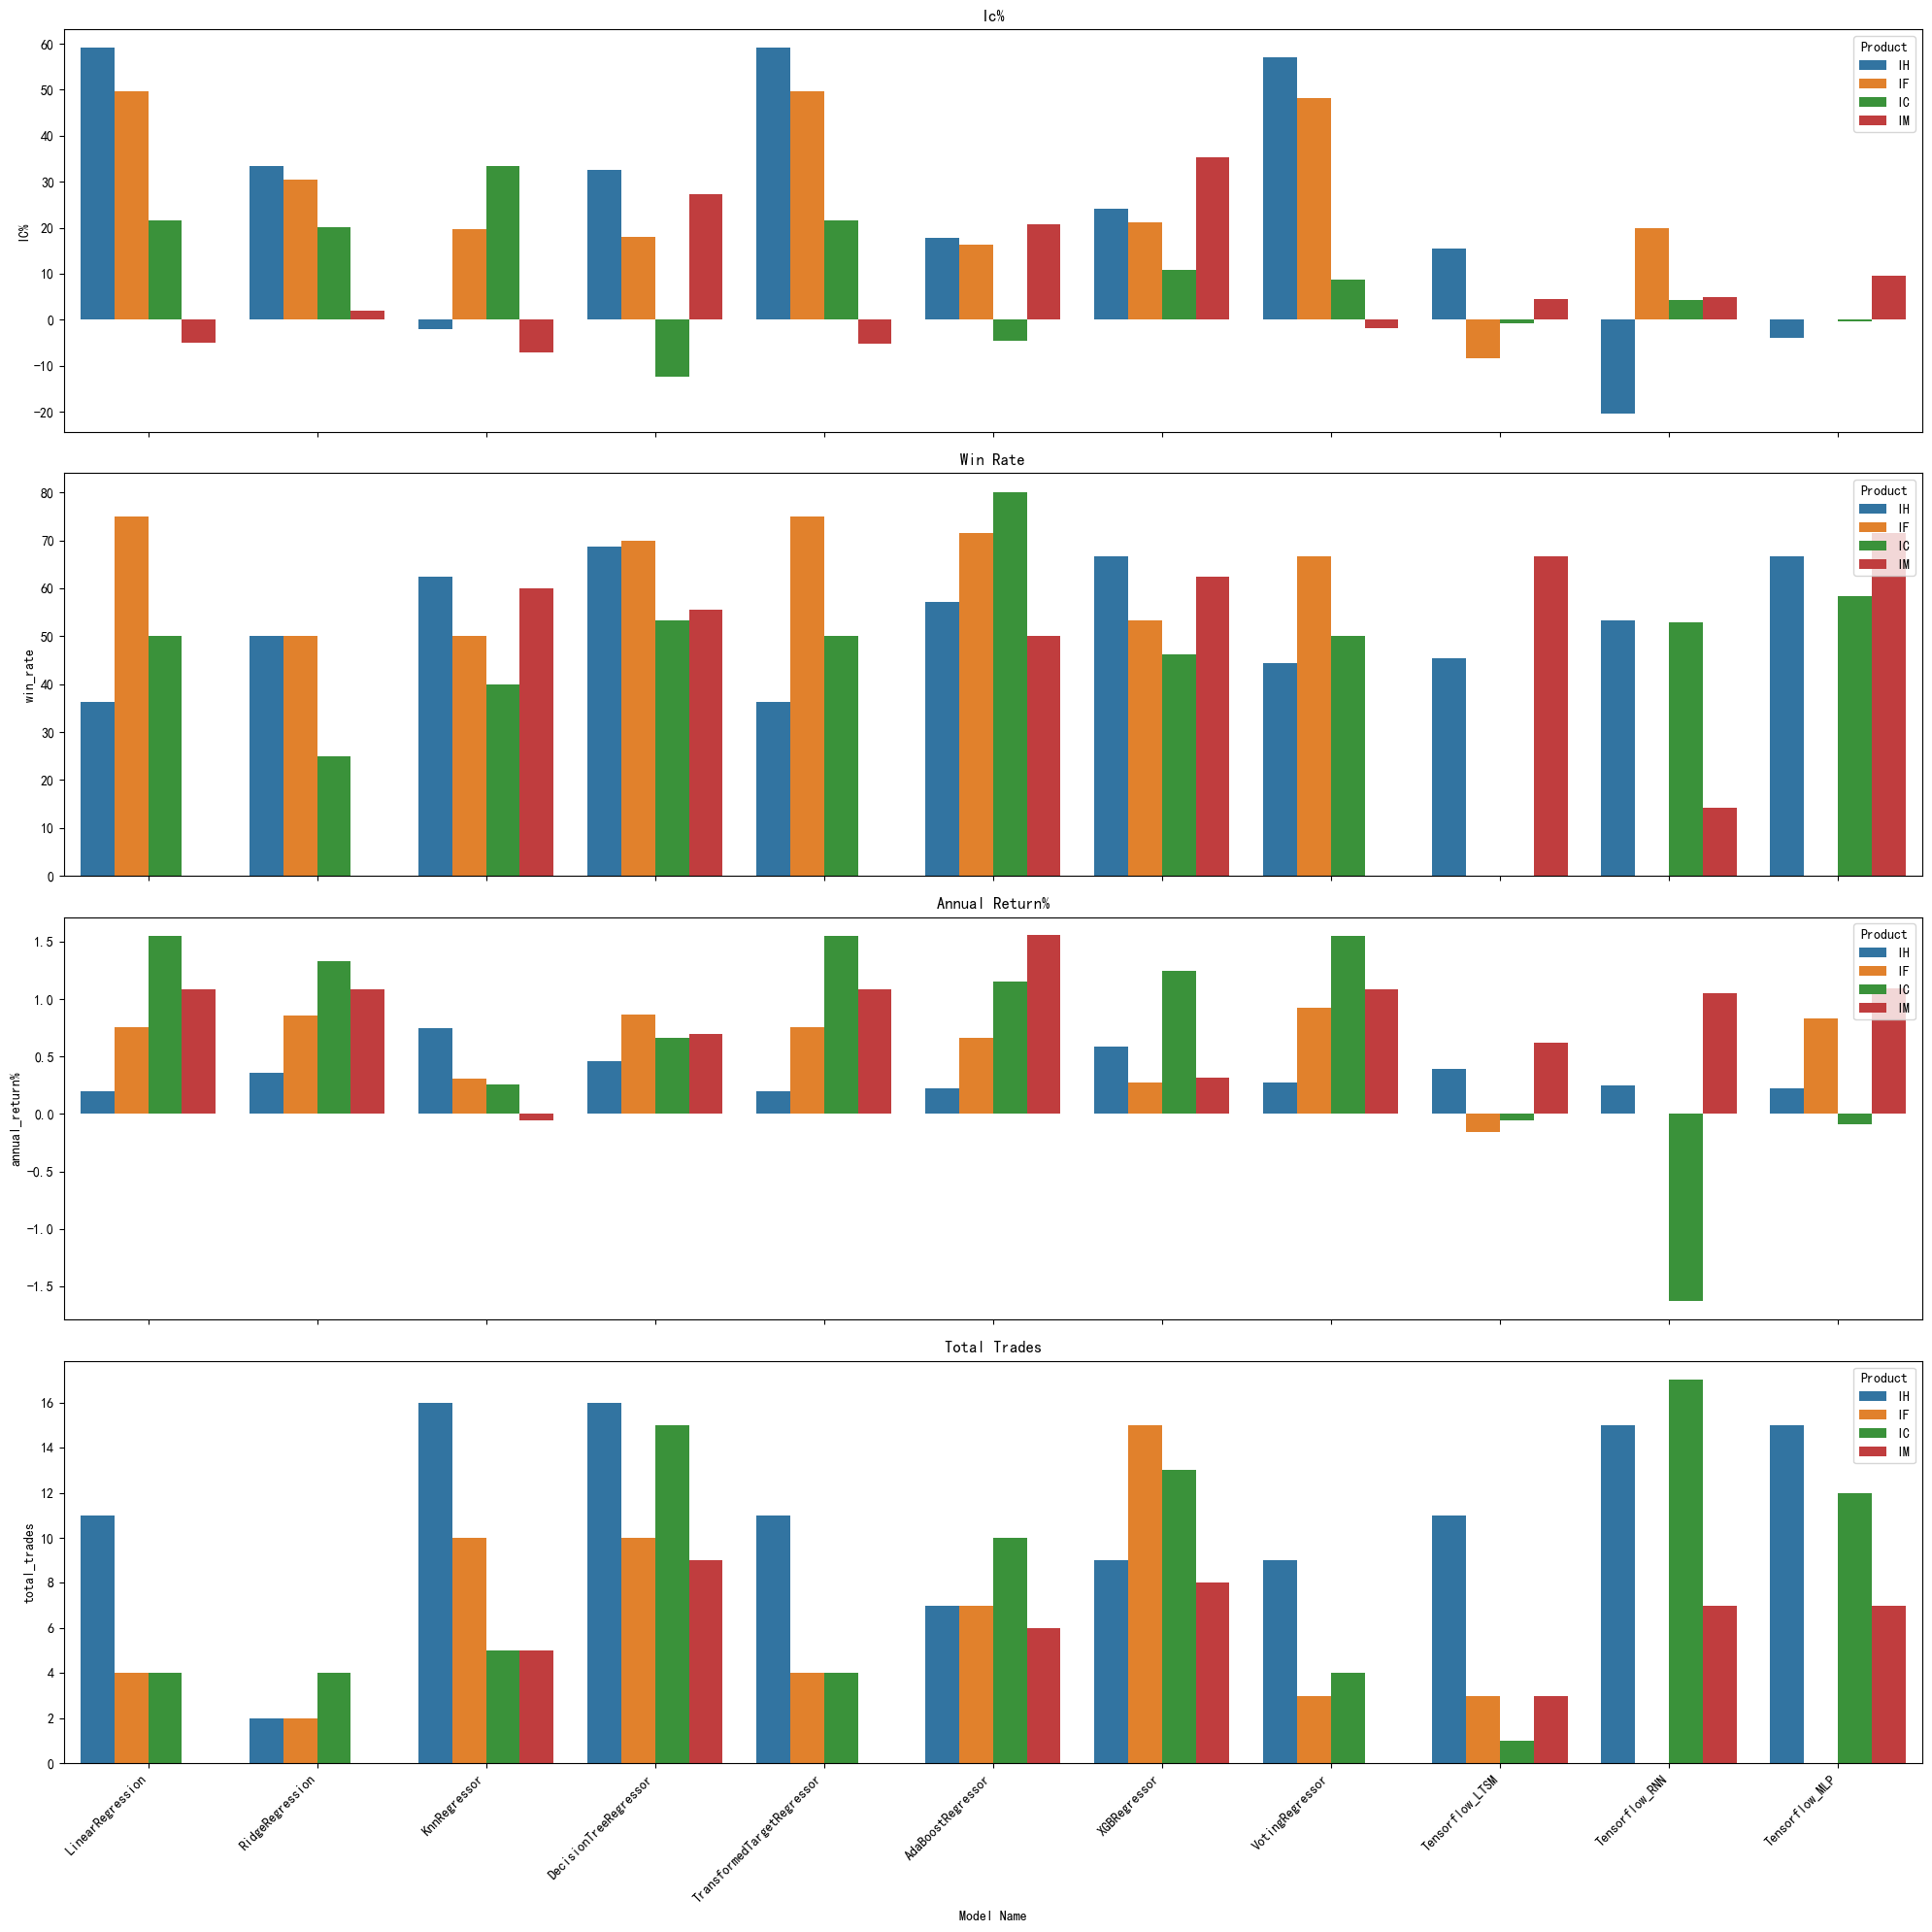

AttributeError: 'Figure' object has no attribute 'write_image'

In [ ]:
metrics = ['IC%','win_rate', 'annual_return%', 'total_trades']
n_metrics = len(metrics)
n_metrics = len(metrics)
fig, axes = plt.subplots(n_metrics, 1, figsize=(20, 5 * n_metrics), sharex=True)

# Handle case where there's only one metric
if n_metrics == 1:
    axes = [axes]

# Create a subplot for each metric
for i, (metric, ax) in enumerate(zip(metrics, axes)):
    sns.barplot(x='model_name', y=metric, hue='product', data=df_backtest_result, ax=ax)
    ax.set_title(f'{metric.replace("_", " ").title()}')  # Dynamic title based on metric
    ax.set_xlabel('')  # Remove x-axis label for all but the bottom subplot
    ax.legend(title='Product', loc='upper right')  # Ensure legend is visible

# Set x-axis label only for the bottom subplot
axes[-1].set_xlabel('Model Name')
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
fig.savefig("images/backtrader_test_result.png")

### test with only important features

In [2]:
products='IH'
df_result= train_predict_one_model(products, 'VotingRegressor')
voting_model=get_model(df_result, 'VotingRegressor').values[0]
feature_names=get_deature_names(df_result)

Train, test and predict on CSI future contract:"IH"...
510050.SS already exists, skip downloading...


In [3]:

n_features=50
important_features= get_top_feature_importance(voting_model, feature_names, n_features)


df_backtest_result= backtest_all_products(products,important_features, verbose=0, epochs=200)
print(df_backtest_result)



Feature Importance for LinearRegression:
510050.SS already exists, skip downloading...
              LinearRegression: product:   IH   Final Portfolio Value:    104102.21     annual_return: 0.73%     win_rate: 42.86%   total_trades:   7  Sharpe Ratio: 0.11      max drawdown: 2.20
               RidgeRegression: product:   IH   Final Portfolio Value:    104102.21     annual_return: 0.73%     win_rate: 42.86%   total_trades:   7  Sharpe Ratio: 0.11      max drawdown: 2.20
                  KnnRegressor: product:   IH   Final Portfolio Value:    101211.60     annual_return: 0.22%     win_rate: 46.67%   total_trades:  15  Sharpe Ratio: 0.02      max drawdown: 2.53
         DecisionTreeRegressor: product:   IH   Final Portfolio Value:    101631.13     annual_return: 0.29%     win_rate: 50.00%   total_trades:  10  Sharpe Ratio: 0.06      max drawdown: 2.77
    TransformedTargetRegressor: product:   IH   Final Portfolio Value:    104102.21     annual_return: 0.73%     win_rate: 42.86%   tota

I0000 00:00:1753042184.768964  209183 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA T1000, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-07-20 13:12:50.185215: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-20 13:12:50.233637: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this bina

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
               Tensorflow_LTSM: product:   IH   Final Portfolio Value:    101601.41     annual_return: 0.29%     win_rate: 100.00%   total_trades:   2  Sharpe Ratio: 0.04      max drawdown: 2.39


2025-07-20 13:15:09.774200: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-20 13:15:09.822146: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
                Tensorflow_RNN: product:   IH   Final Portfolio Value:    104122.65     annual_return: 0.74%     win_rate: 64.29%   total_trades:  14  Sharpe Ratio: 0.11      max drawdown: 1.71


2025-07-20 13:15:16.216436: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2025-07-20 13:17:03.912297: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


                Tensorflow_MLP: product:   IH   Final Portfolio Value:    102160.27     annual_return: 0.39%     win_rate: 50.00%   total_trades:  14  Sharpe Ratio: 0.05      max drawdown: 3.28
   product                  model_name        IC%       MSE  annual_return%  \
0       IH            LinearRegression   4.821008  0.000099        0.733963   
1       IH             RidgeRegression   4.988626  0.000099        0.733963   
2       IH                KnnRegressor  22.329981  0.000109        0.219302   
3       IH       DecisionTreeRegressor  38.522806  0.000106        0.294738   
4       IH  TransformedTargetRegressor   4.821008  0.000099        0.733963   
5       IH           AdaBoostRegressor  19.089189  0.000051        0.442664   
6       IH                XGBRegressor  20.543367  0.000093        1.237833   
7       IH             VotingRegressor  30.302909  0.000078        0.884072   
8       IH             Tensorflow_LTSM  21.487207  0.000086        0.289402   
9       IH      

In [5]:
df_result= train_predict_one_model(products, 'VotingRegressor')
voting_model=get_model(df_result, 'VotingRegressor').values[0]
feature_names=get_deature_names(df_result)

n_features=100
important_features= get_top_feature_importance(voting_model, feature_names, n_features)
df_backtest_result= backtest_all_products(products,important_features, verbose=0, epochs=200)

Train, test and predict on CSI future contract:"IH"...
510050.SS already exists, skip downloading...

Feature Importance for LinearRegression:
510050.SS already exists, skip downloading...
              LinearRegression: product:   IH   Final Portfolio Value:    98810.71     annual_return: -0.22%     win_rate: 0.00%   total_trades:   2  Sharpe Ratio: -0.22      max drawdown: 1.19
               RidgeRegression: product:   IH   Final Portfolio Value:    98810.71     annual_return: -0.22%     win_rate: 0.00%   total_trades:   2  Sharpe Ratio: -0.22      max drawdown: 1.19
                  KnnRegressor: product:   IH   Final Portfolio Value:    101519.92     annual_return: 0.27%     win_rate: 57.14%   total_trades:  14  Sharpe Ratio: 0.04      max drawdown: 3.02
         DecisionTreeRegressor: product:   IH   Final Portfolio Value:    101642.36     annual_return: 0.30%     win_rate: 55.00%   total_trades:  20  Sharpe Ratio: 0.04      max drawdown: 3.13
    TransformedTargetRegressor: pro

2025-07-20 13:22:57.667527: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
               Tensorflow_LTSM: product:   IH   Final Portfolio Value:    97122.86     annual_return: -0.53%     win_rate: 0.00%   total_trades:   3  Sharpe Ratio: -0.24      max drawdown: 3.01


2025-07-20 13:25:15.743964: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-20 13:25:15.792217: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step
                Tensorflow_RNN: product:   IH   Final Portfolio Value:    104169.94     annual_return: 0.75%     win_rate: 50.00%   total_trades:   6  Sharpe Ratio: 0.07      max drawdown: 5.40


2025-07-20 13:25:22.993546: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


2025-07-20 13:27:14.631476: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


                Tensorflow_MLP: product:   IH   Final Portfolio Value:    100923.44     annual_return: 0.17%     win_rate: 41.18%   total_trades:  17  Sharpe Ratio: 0.01      max drawdown: 5.17
